In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_4/Villin_Lab/2F4K.protein.pdb'
trajectory='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_4/Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_4/Villin_Lab/2f4K.xray.CA.pdb'
outdir='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_4/out_dir'
if not os.path.exists('out_dir'):
    os.makedirs('out_dir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)



outdir: /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_4/out_dir
pdb: /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_4/Villin_Lab/2F4K.protein.pdb
trjaectory: /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_4/Villin_Lab/2F4K.protein.s10.dcd


In [3]:
stride_sel=10
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [6]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


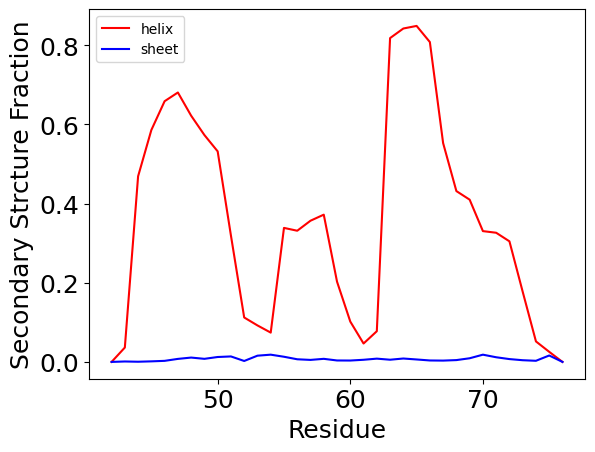

In [8]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [9]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [10]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [11]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




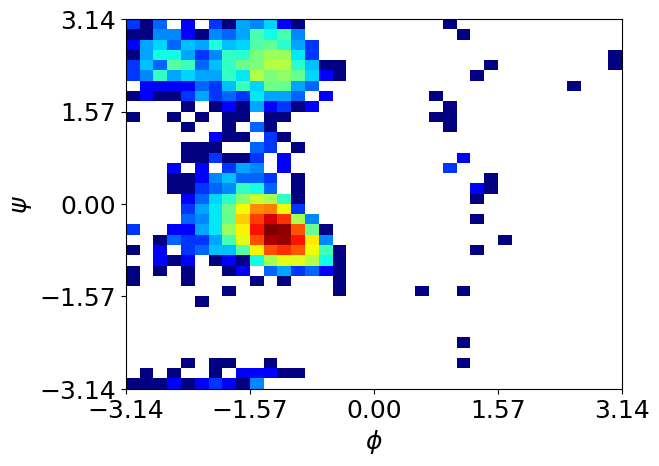

In [12]:
plot_phipsi(45)


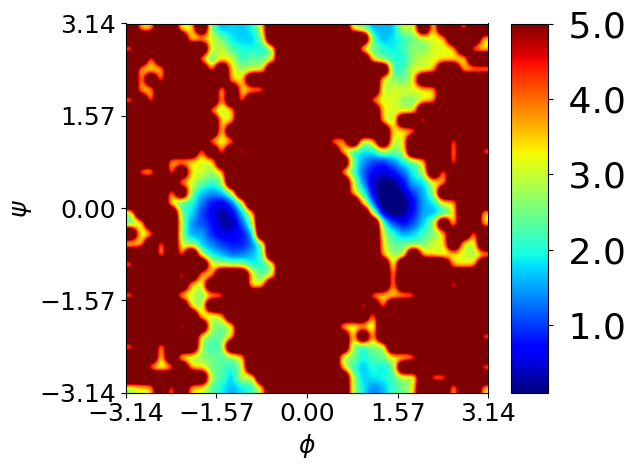

In [13]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(52)

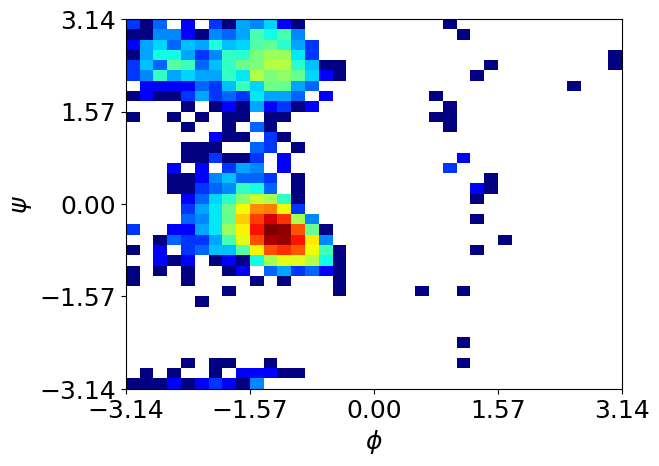

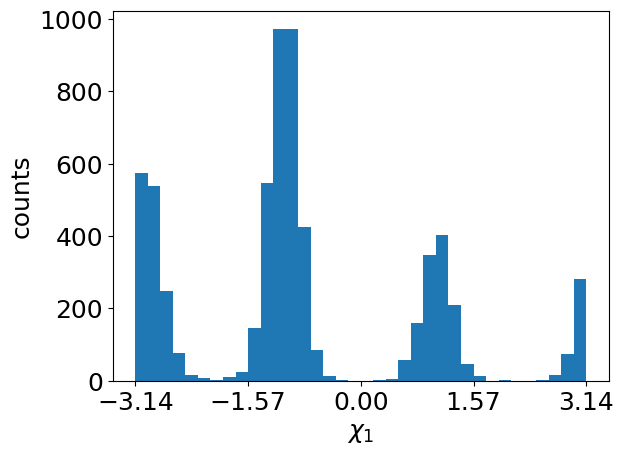

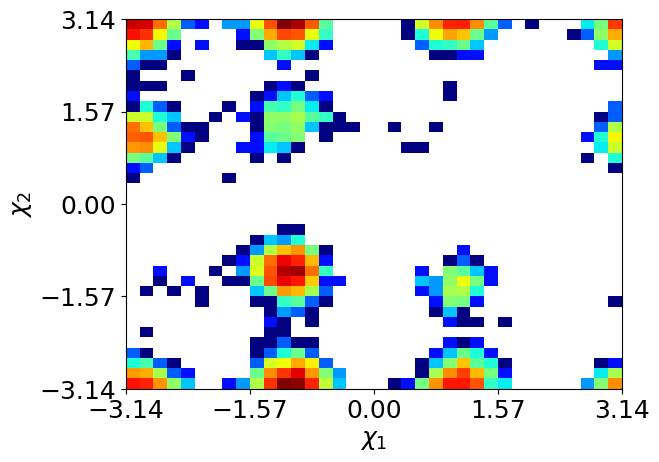

In [14]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [15]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [16]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 6280 frames, 35 atoms, 35 residues, and unitcells at 0x14f8672d0>

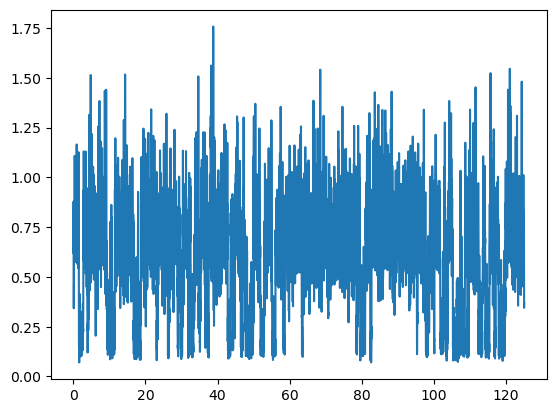

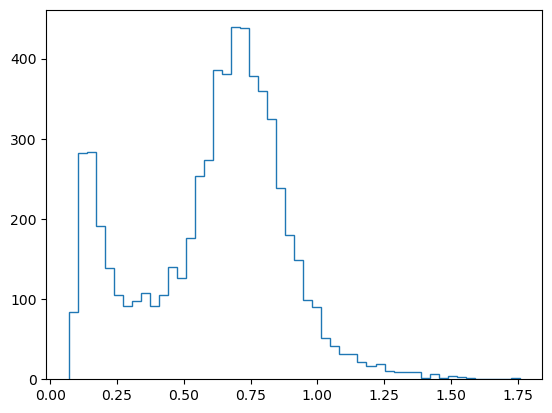

In [17]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

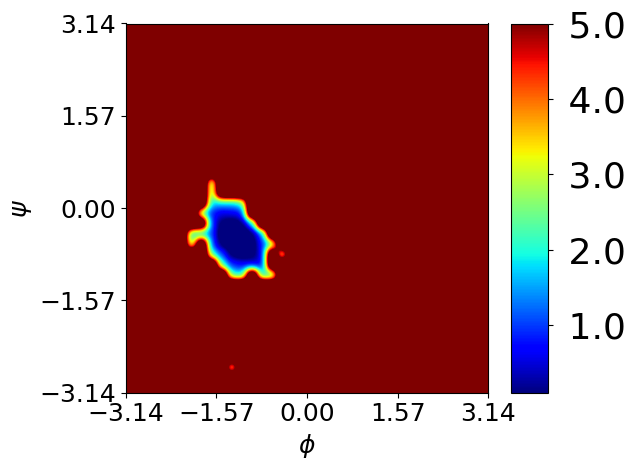

In [18]:
def plot_phipsi_FES_frames(res,frames):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res][frames],dihedral_dict['phi'][res][frames],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return


native_frames=np.where(rmsd<0.25)[0]
len(native_frames)
trj[native_frames].save_dcd(outdir+'native.dcd')

plot_phipsi_FES_frames(45,native_frames)


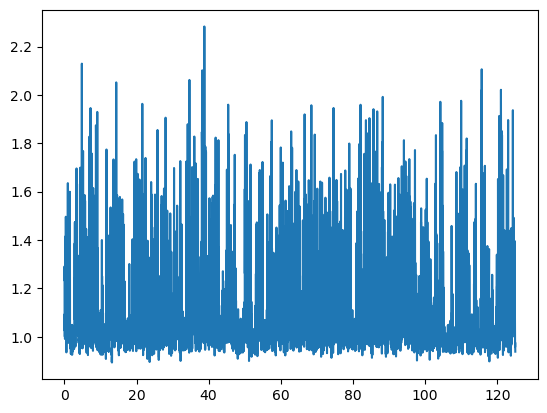

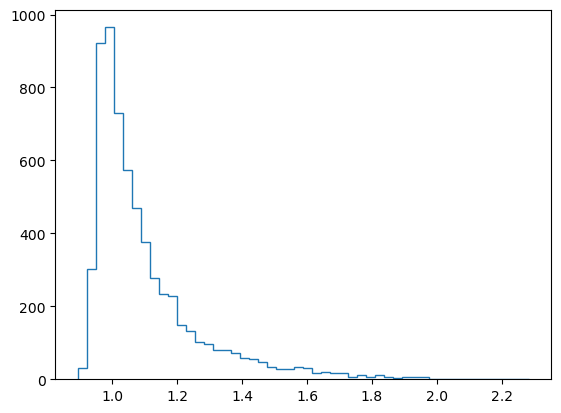

In [19]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [20]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(6280, 2)


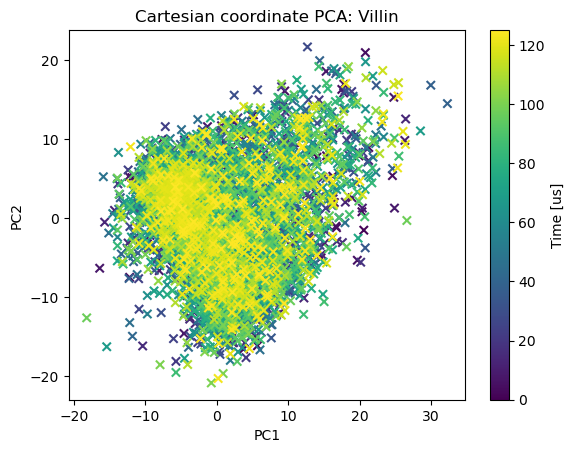

In [21]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

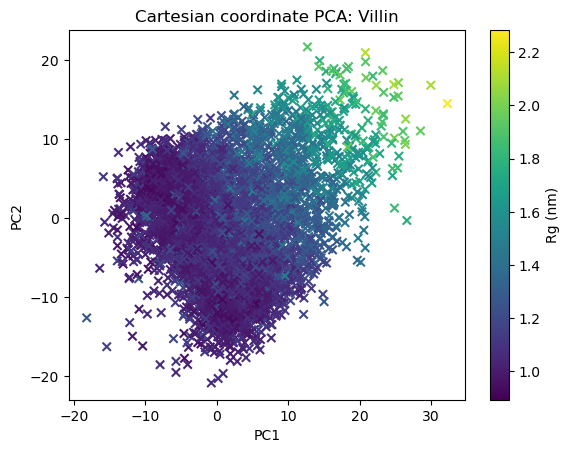

In [22]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

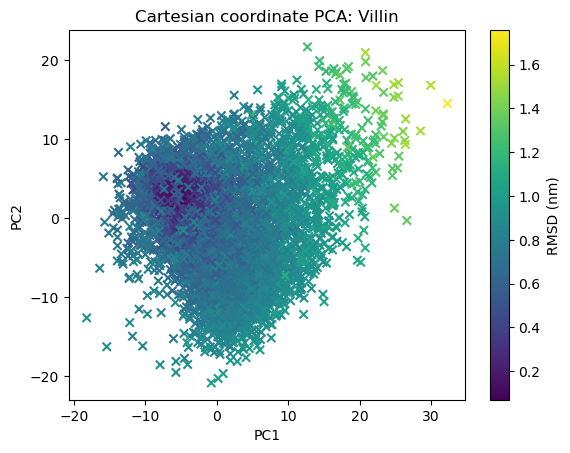

In [23]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

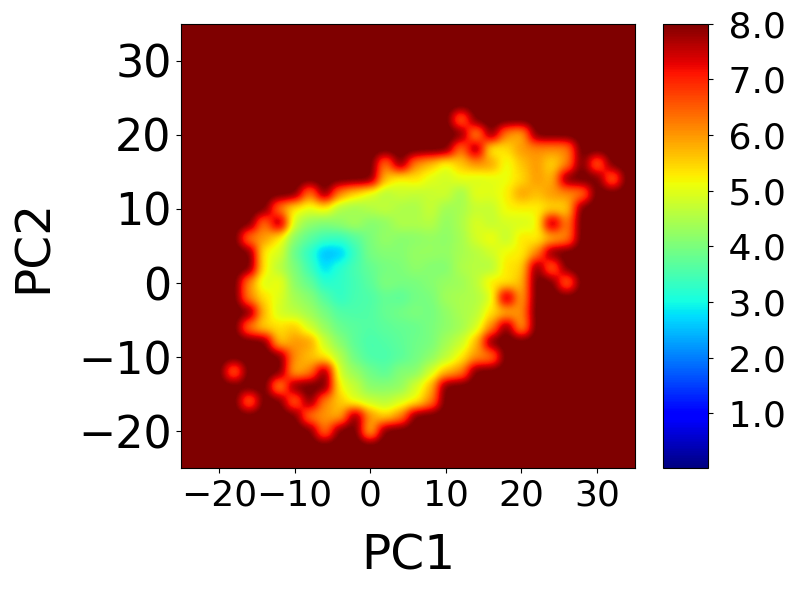

In [24]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [25]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters



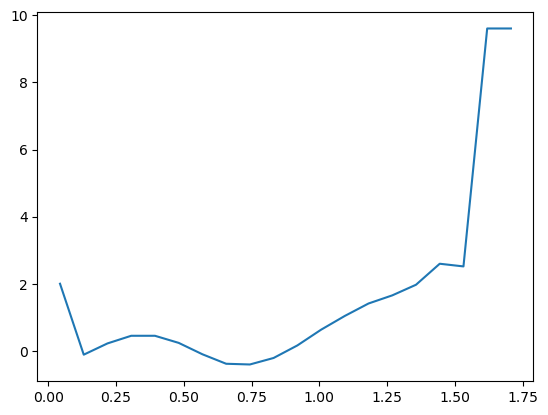

In [26]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)

In [27]:
#Possible Homework Prompt:
#Visualize the lowest free energy basin
basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))[0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

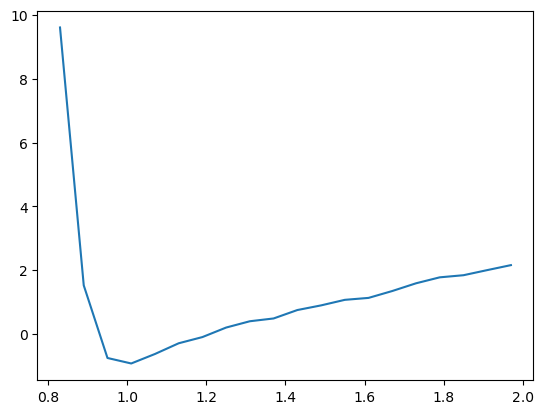

In [28]:
#RG vs RMSD
dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)

plt.plot(xedges,dG_rg)

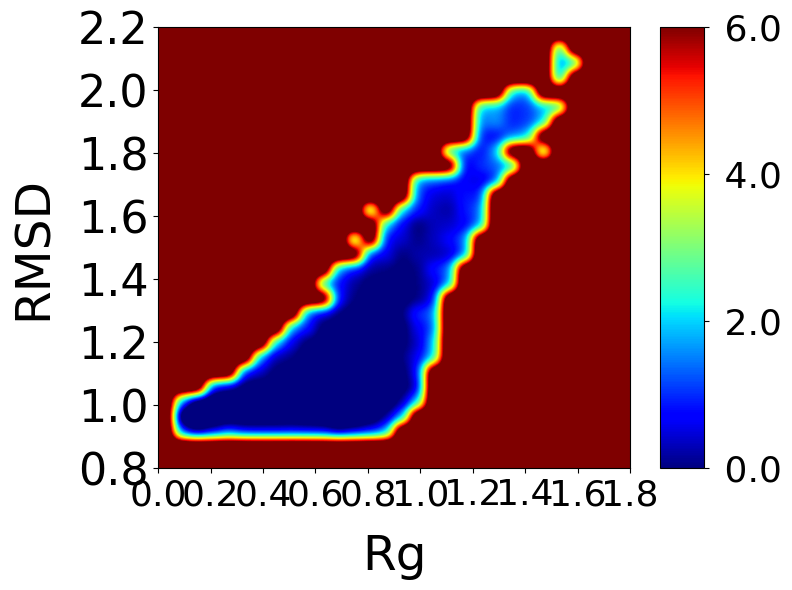

In [29]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

In [30]:
#borrowing quicker contact map code from Anjali/Tommy 
import itertools
def product(x:np.ndarray, y:np.ndarray):
    return np.asarray(list(itertools.product(x, y)))


def combinations(x):
    return np.asarray(list(itertools.combinations(x, 2)))

def residue_distances(traj,
                      index_0: np.ndarray,
                      index_1: np.ndarray = None, dist=False):
    """ Brand new distance matrix. the inter case returns a compressed contact probability matrix, 
    but if idx=True, then it will return the whole distance matrix for ya :) """
    # intra distance case
    if index_1 is None:
        indices = combinations(index_0)
        return md.compute_contacts(traj, indices)[0], indices

    # inter distance case
    else:
        indices = product(index_0, index_1)
        if dist == True: 
            return md.compute_contacts(traj, indices)[0]
        else: 
            dist = md.compute_contacts(traj, indices)[0]
            return np.where(dist>.5, 0, 1)

        
def to_distance_matrix(distances: np.ndarray,
                       n: int,
                       m: int = None,
                       d0: int = 1):
    assert (distances.ndim == 2), "Must input a flattened distance array (n,d)"

    # info about flattened distance matrix
    N, d = distances.shape

    # intra molecular distances
    if m is None:
        matrix = np.zeros([N] + [n] * 2)
        i, j = np.triu_indices(n, d0)
        matrix[:, i, j] = distances
        return matrix + matrix.transpose(0, 2, 1)

    else:
        assert d == n * m, \
            "Given dimensions (n,m) do not correspond to the dimension of the flattened distances"

        return distances.reshape(-1, n, m)

In [31]:
dist, idx = residue_distances(trj, np.arange(34))
fixed_dist = to_distance_matrix(dist, 34)

In [32]:
fixed_dist = to_distance_matrix(dist, 34)

In [33]:
contact=np.where(fixed_dist<0.5, 1, 0)

In [34]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

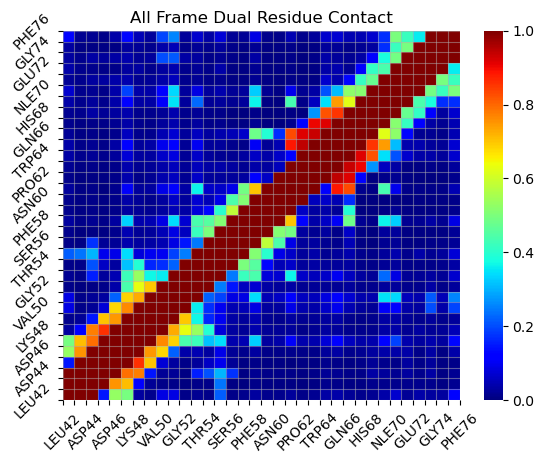

In [35]:
ax = sns.heatmap(contact.mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('All Frame Dual Residue Contact')
plt.show()

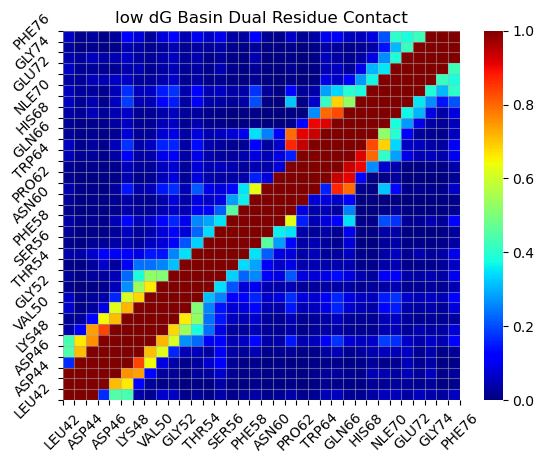

In [36]:
ax = sns.heatmap(contact[basin_frames].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('low dG Basin Dual Residue Contact')
plt.show()

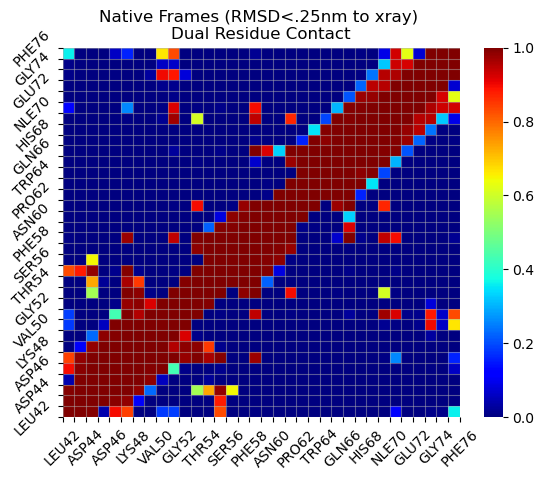

In [37]:
ax = sns.heatmap(contact[native_frames].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Native Frames (RMSD<.25nm to xray) \nDual Residue Contact')
plt.show()

In [38]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [39]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)

In [40]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

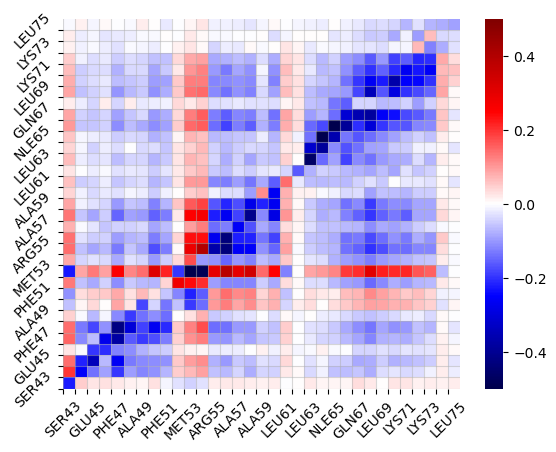

In [41]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

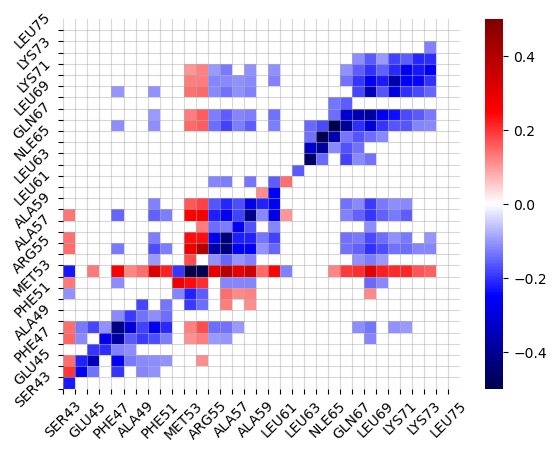

In [42]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

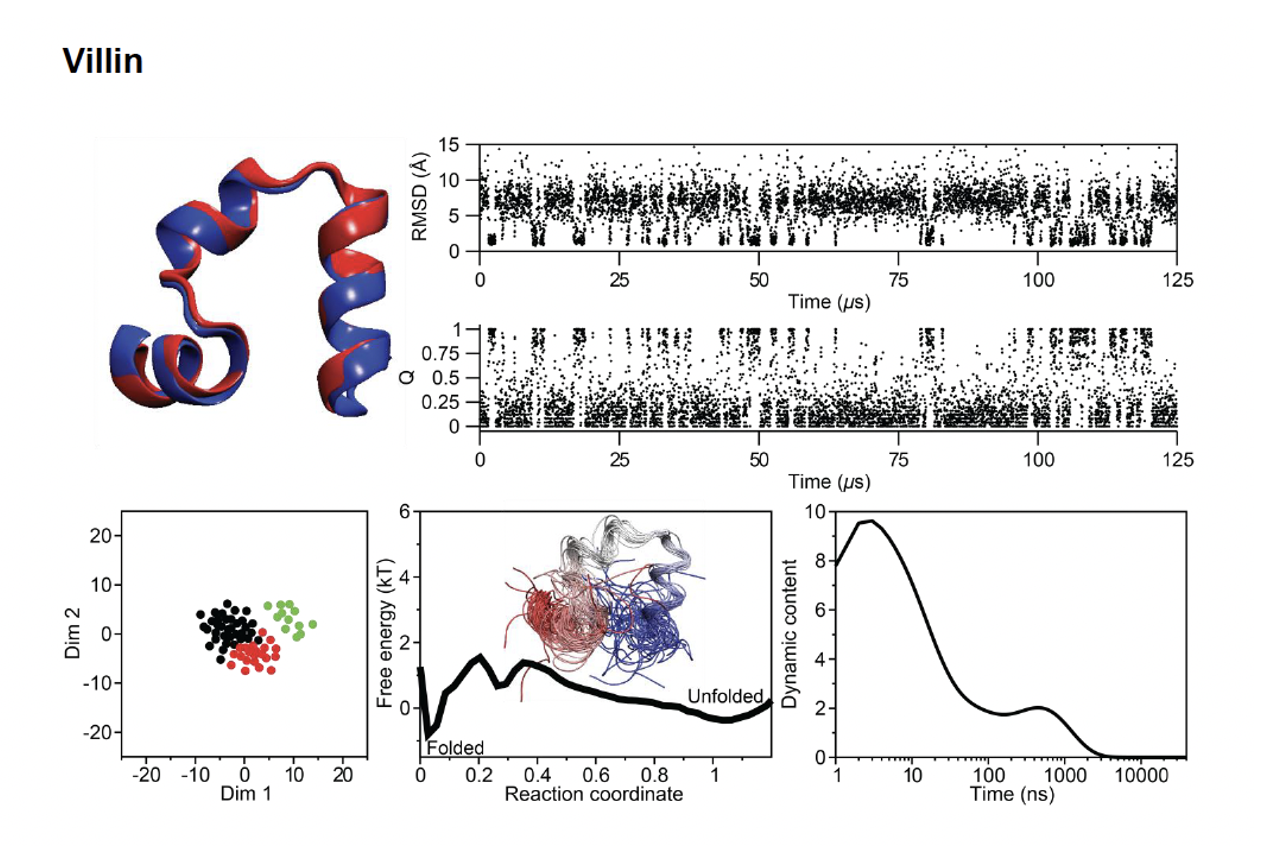

First we need to determine the native contacts and calculate Q

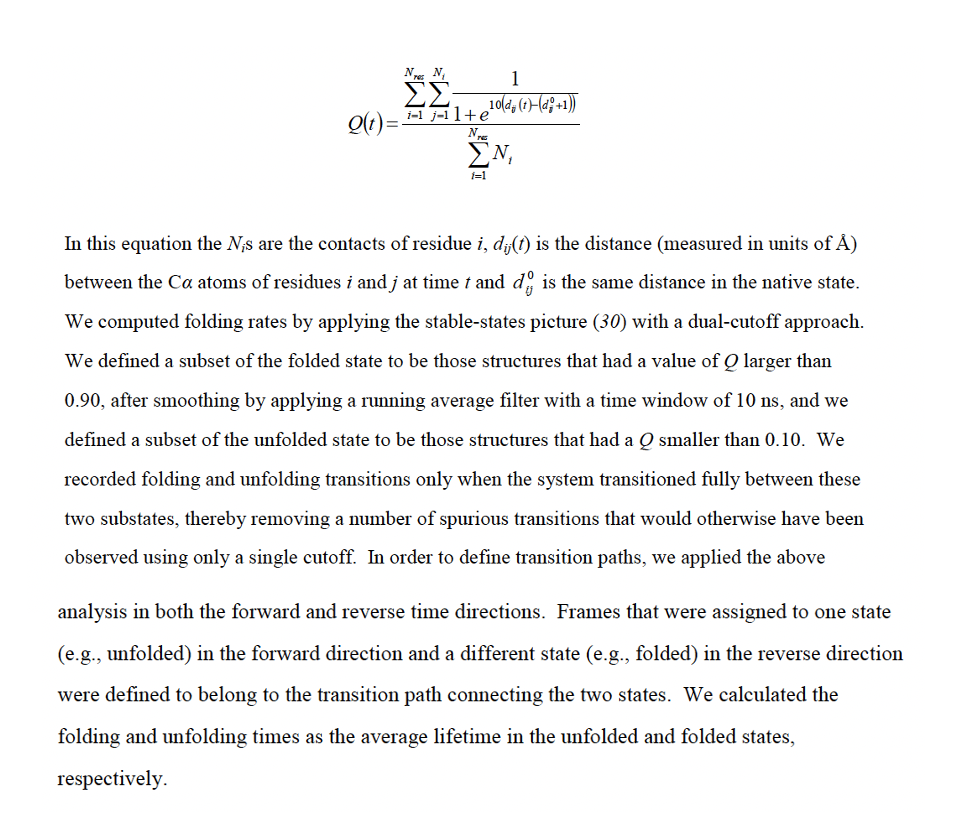

In [43]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x14f4bc490>

In [44]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [45]:
Native_Contacts=np.where(native_distance_matrix1D<10)
Native_Contact_Distances=native_distance_matrix1D[Native_Contacts]
np.shape(Native_Contact_Distances)

(148,)

In [46]:
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[Native_Contacts]


In [47]:
np.shape(Traj_Native_Contact_Distances)

(148, 6280)

In [48]:
for i in range(0,len(Native_Contact_Distances)):
  print(Native_Contact_Distances[i],Traj_Native_Contact_Distances[i])

9.288557 [16.155031 10.791452 12.989177 ...  9.819974 13.44309  12.631355]
9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.792494 [17.497013 20.938164 14.502391 ...  9.647299 10.491154 12.31331 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
7.2052145 [18.622604 19.704548 15.620064 ... 10.816223 11.794368

In [49]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_Native_Contact_Distances))
for i in range(0,len(Native_Contact_Distances)):
 Native_Contact_Distances_nframes[i]=Native_Contact_Distances[i]

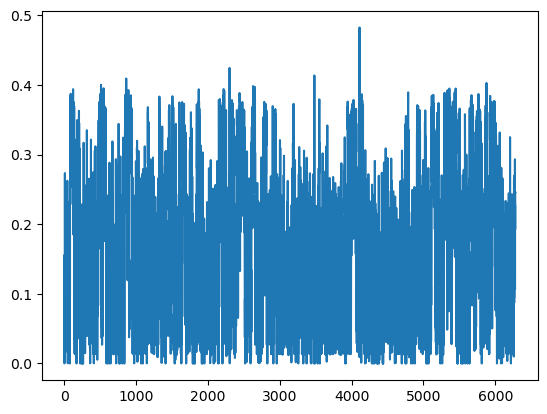

(array([1.087e+03, 1.503e+03, 9.610e+02, 6.850e+02, 4.700e+02, 4.940e+02,
        5.690e+02, 4.810e+02, 2.900e+01, 1.000e+00]),
 array([1.28075769e-25, 4.82478970e-02, 9.64957939e-02, 1.44743691e-01,
        1.92991588e-01, 2.41239485e-01, 2.89487382e-01, 3.37735279e-01,
        3.85983176e-01, 4.34231073e-01, 4.82478970e-01]),
 [<matplotlib.patches.Polygon at 0x180262150>])

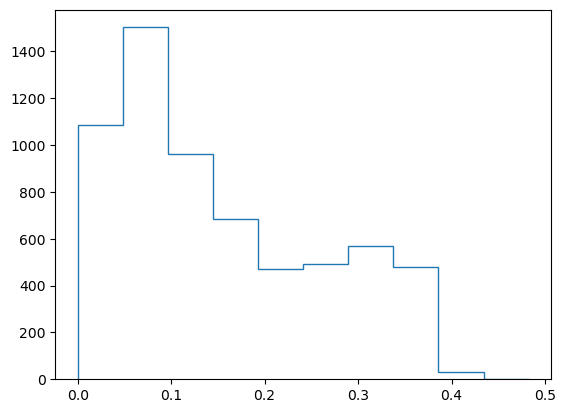

In [50]:
#looking at the rxn coordinates to figure out pathways using paper 

Q=1/(1+np.exp(10*(Traj_Native_Contact_Distances-(Native_Contact_Distances_nframes+1))))

Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_Contact_Distances)
plt.plot(Q)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')

In [51]:
#Now Lets Consider a "Native Portion of the Trajectory"
native_frames.shape

(1016,)

In [52]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [53]:
np.shape(native_distance_matrix1D)

(702,)

In [54]:
np.shape(traj_CA_distance_matrix1D)

(702, 6280)

In [55]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 1016)

In [56]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 550, 557,
       569, 570, 635, 636, 684])

In [57]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(44, 6280)

In [58]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i].mean())

9.985726 16.43719
10.452459 14.803059
9.704253 15.123908
9.60349 12.762021
7.0967283 12.718798
7.0852814 13.380732
9.99271 14.831583
9.574567 11.926988
8.303897 12.24485
9.653462 13.321598
9.633482 11.922619
10.225195 12.814175
6.8318415 11.116647
9.7255125 13.30054
9.797035 14.181551
7.3131294 15.601464
9.571478 15.678847
7.4795647 13.722557
8.667388 13.872618
7.7988334 15.631148
9.60349 12.762021
9.574567 11.926988
10.452459 14.803059
7.0967283 12.718798
8.303897 12.24485
9.633482 11.922619
9.985726 16.43719
9.704253 15.123908
7.0852814 13.380732
9.653462 13.321598
10.225195 12.814175
6.8318415 11.116647
9.99271 14.831583
9.7255125 13.30054
6.6416473 10.513765
9.298402 13.762217
6.6416473 10.513765
7.4795647 13.722557
9.298402 13.762217
9.797035 14.181551
8.667388 13.872618
7.3131294 15.601464
7.7988334 15.631148
9.571478 15.678847


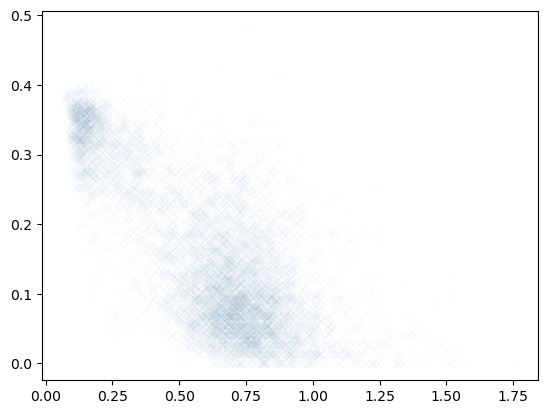

In [59]:
#Plot Q and a Histogram
plt.scatter(rmsd,Q,marker='x',linewidth=.01)

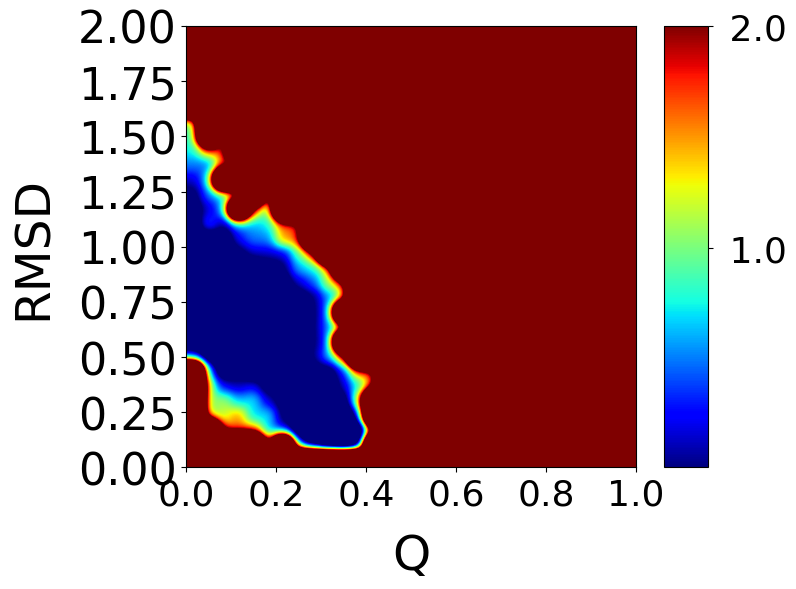

In [60]:
dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.tight_layout()

Text(0, 0.5, '$\\Delta$G')

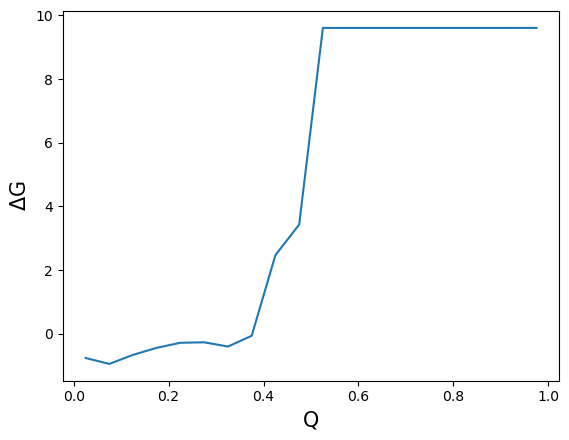

In [61]:
dG_Q,xedges=free_energy1D(Q,300,0,1,20)

plt.plot(xedges,dG_Q)
plt.xlabel("Q",size=15)
plt.ylabel("$\Delta$G",size=15)

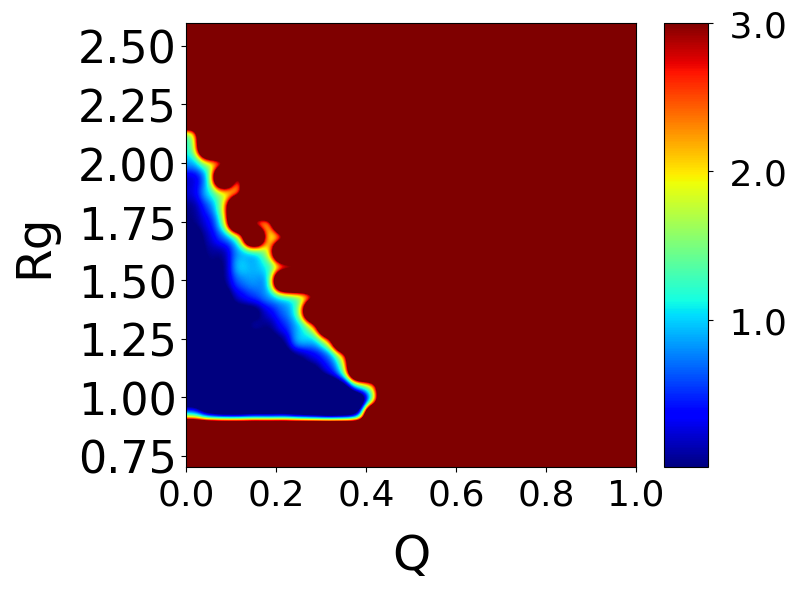

In [62]:
dG,xedges,yedges=free_energy(rg, Q, 300, 0.7, 2.6, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2,3]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()

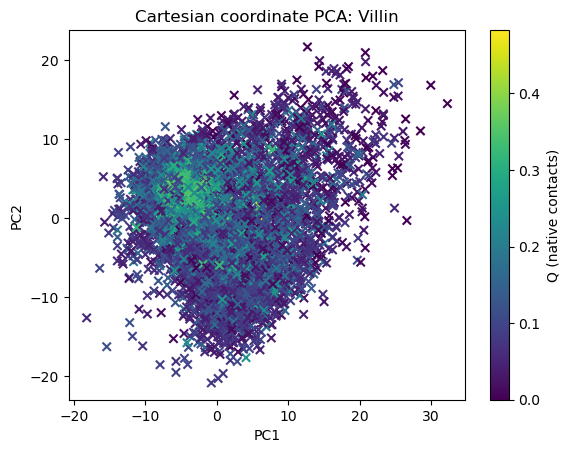

In [63]:
### plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=Q)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Q (native contacts)')

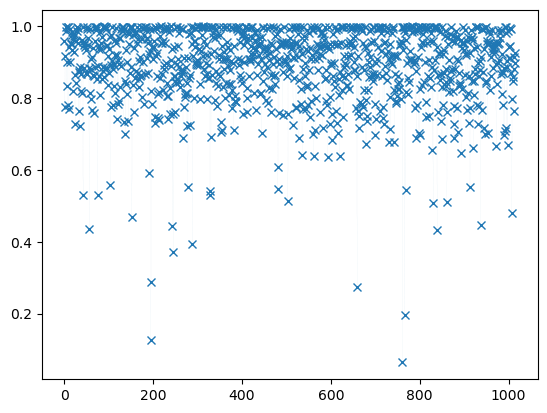

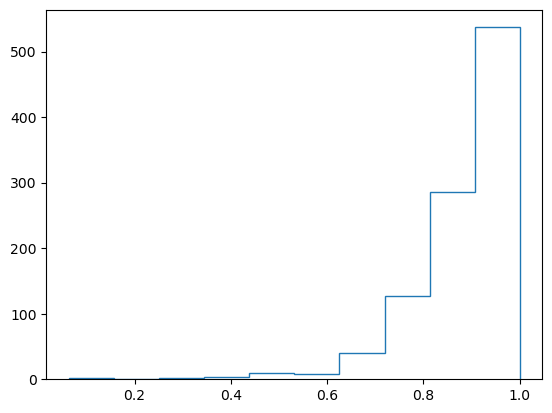

In [64]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q

#note: Traj_CA_Distnaces not distances! spelling was wrong and everything was already defined lol 

#redefine Q so its only the native frames 
Q=1/(1+np.exp(10*(Traj_CA_Distnaces[:,native_frames]-(Native_Contact_Distances_nframes+1)[:,native_frames])))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)

plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

In [65]:
#Filter the native distances to only include distances where the average value < 10A in the native frames 


In [66]:
#Check that we're comparing all the correct distances 


In [67]:
#Plot Q using only our native frames


In [68]:
#Lets Calculate Our Transition Paths using the Dual Cutoff Approach 

In [69]:
#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations


# **HOMEWORK PROBLEM: DUAL CUTOFF APPROACH**

Let's start by defining all the reactinocoordinates we're interested in (will look at everything, not just the native frames

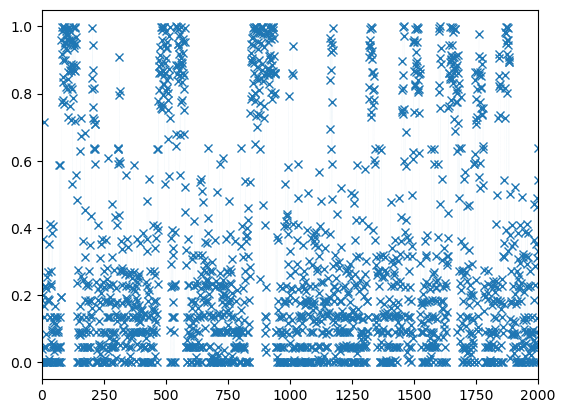

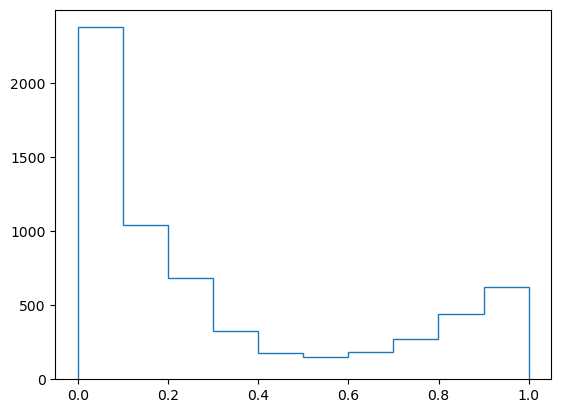

In [70]:
#re-define Q again since I changed it in the cells above
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)

plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

In [71]:
Q.shape

(6280,)

We want to find paths that show these full transitions from unfolded to folded (so going from <0.1 to >0.9). 

In [72]:
#To find where Q is greater than 0.9 and less than 0.1. 
#This gives us index values we can later use to plot the contacts to analyze the differences \n between the states 
folded_frames = np.where(Q > 0.90)[0]
unfolded_frames = np.where(Q < 0.10)[0]
print("unfolded:", len(unfolded_frames))
print("folded:", len(folded_frames))

unfolded: 2380
folded: 625


Goal is to find the transition paths between these frames over time.  

In [73]:
#first step is to set our reaction coord boundaries. 
#We're also gonna set up a binary like in past notebooks to figure out frames that are folded vs those that are unfolded
folded = np.where(Q > 0.9, 2, 0)
unfolded = np.where(Q < 0.1, 1, 0)
binary = folded + unfolded

# Find the non-zero elements (where frames are either folded/unfolded. We don't really care about the middle ones here
non_zero_indices = np.where(binary != 0)[0]
no_zeros = binary[binary != 0]

# Now, we're going to figure out everytime we have frames that go from folded to unfolded to find these transition paths 
def find_turning_points(no_zeros):
    turning_points = []
    for i in range(1, len(no_zeros)):
        if no_zeros[i] != no_zeros[i - 1]:
            turning_points.append(i)
    return np.array(turning_points)

#break it down by the forward reaction pathway 
turning_points_forward = find_turning_points(no_zeros)
trans_end = non_zero_indices[turning_points_forward]

# and then by the reverse 
no_zeros_reversed = no_zeros[::-1]
turning_points_reverse = find_turning_points(no_zeros_reversed)
trans_start = non_zero_indices[::-1][turning_points_reverse]

# organize our array so that we can better analyze 
trans_start = np.sort(trans_start)
trans_end = np.sort(trans_end)

# lets get the indices of turning points to plot and visualize the reaction a bit better
tp_indices = []
for start, end in zip(trans_start, trans_end):
    if start < end:
        tp_indices.append(np.arange(start + 1, end))
transition_path_indices = np.concatenate(tp_indices)

print(transition_path_indices)


[  77   78  138  139  140  141  195  196  197  198  199  200  201  202
  206  207  208  209  210  211  212  213  214  215  216  299  300  301
  302  303  304  305  306  307  308  309  310  311  312  314  315  316
  465  466  467  468  469  470  471  472  473  474  475  516  536  537
  538  539  540  541  578  579  580  837  838  839  840  841  842  896
  897  898  899  903  904  905  937  938  939  940  941  942 1009 1010
 1011 1013 1160 1161 1174 1175 1317 1318 1333 1334 1335 1336 1337 1338
 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1445 1446
 1447 1448 1449 1450 1451 1452 1453 1454 1455 1463 1464 1496 1497 1517
 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1598 1599 1600 1632
 1633 1634 1635 1636 1637 1638 1639 1670 1671 1672 1673 1674 1675 1677
 1678 1679 1681 1682 1683 1684 1685 1686 1687 1760 1761 1774 1775 1776
 1777 1778 1779 1780 1781 1782 1783 1784 1785 1841 1842 1845 1846 1847
 1848 1849 1860 1861 1862 1863 1864 1865 1866 1867 1868 1885 1886 1887
 1888 

Now, we can go through and see where the folding is happening in terms of secondary structure.

Text(0.5, 1.0, 'Folded Frames')

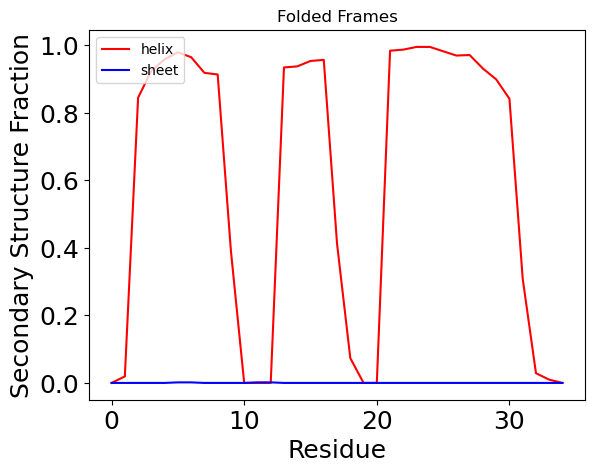

In [74]:
#Folded structure 
Hprop,Eprop=dssp_convert(dssp[folded_frames])
plt.plot(Hprop,c='r',label='helix')
plt.plot(Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Structure Fraction', size=18)
plt.tick_params(labelsize=18)
plt.title('Folded Frames')

Text(0.5, 1.0, 'Unfolded Frames')

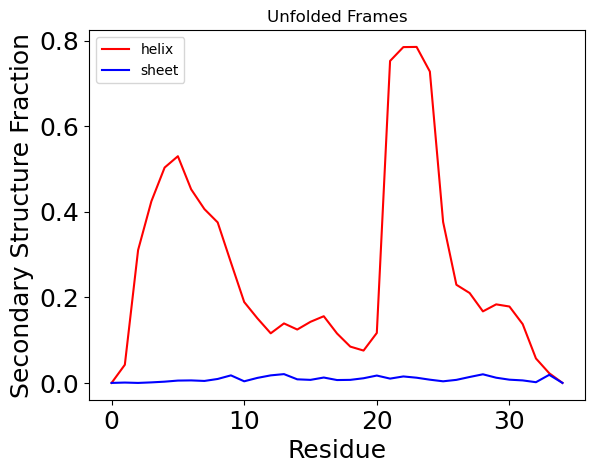

In [75]:
#unfolded 
Hprop,Eprop=dssp_convert(dssp[unfolded_frames])
plt.plot(Hprop,c='r',label='helix')
plt.plot(Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Structure Fraction', size=18)
plt.tick_params(labelsize=18)
plt.title('Unfolded Frames')

Text(0.5, 1.0, 'Transition Frames')

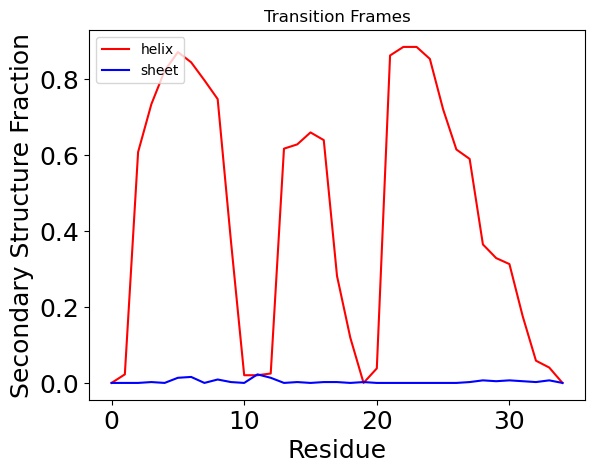

In [76]:
#where is the change happening? looking at transition path 
Hprop,Eprop=dssp_convert(dssp[transition_path_indices])
plt.plot(Hprop,c='r',label='helix')
plt.plot(Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Structure Fraction', size=18)
plt.tick_params(labelsize=18)
plt.title('Transition Frames')

After figuring out the paths, we can look at dual contact maps and see if we can find any patterns that might indicate the folding/unfolding of villin! It looks like the change is happening in the middle helix, which is becoming more folded over time. Contact maps also show these changes in residue-residue interactions.

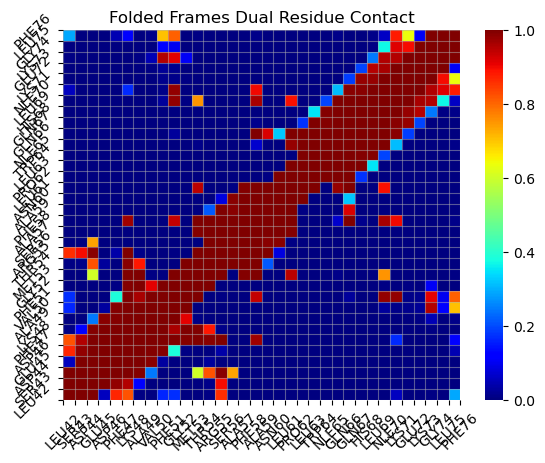

In [77]:
ax = sns.heatmap(contact[folded_frames].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Folded Frames Dual Residue Contact')
plt.show()

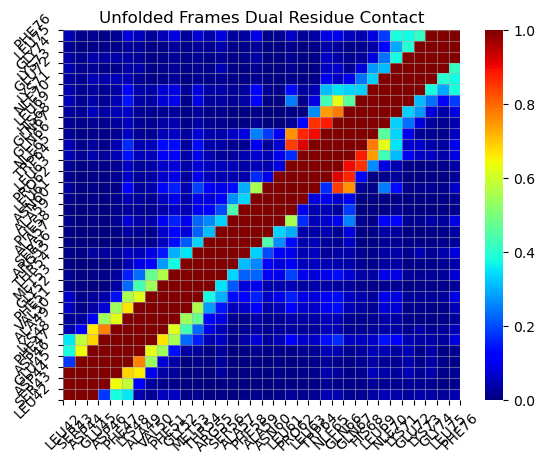

In [78]:
ax = sns.heatmap(contact[unfolded_frames].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Unfolded Frames Dual Residue Contact')
plt.show()

Comparing these plots is visually so nice! Clearly the unfolded dual contact map is showing way less contacts across areas of the sequence! Makes sense, since unfolded, the region is more open/less compact and therefore has less interactions 

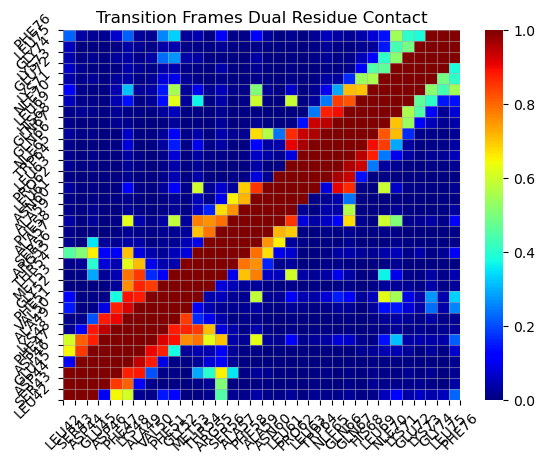

In [79]:
ax = sns.heatmap(contact[transition_path_indices].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Transition Frames Dual Residue Contact')
plt.show()

And if we look at the transition path, the contacts that form are those that resemble the folded frames, to some degree. This is essenitally showing the development of those contacts as the secondary structure (helix in this case) starts to come together! And by the time the protein is folded, some of these contacts become more "established" and some that were involved in folding the protein become weaker/stronger depending on the intearction (eg PHE51 and LEU69 show a stronger interaction in the folded map than in the transition map).

# **Looking more into transition paths**

Everything we looked at above was looking at the complete transition from folded to unfolded (Q was < 0.1 or > 0.9). What about the intermediate pathways showing a not fully folded state? Are there any secondary structures that become important during the folding process? The maps look like we'd just see increasing helix during the transition, but let's check. Maybe we'll find the halfway point of helix formation. Going to repeat the analysis but looking at frames between 0.35-0.45 vs those at 0.9. 

In [80]:
folded_frames = np.where(Q > 0.90)[0]
intermed_frames = np.where((Q < 0.45) & (Q > 0.35))[0]  
print("unfolded:", len(unfolded_frames))
print("folded:", len(folded_frames))

unfolded: 2380
folded: 625


In [81]:
folded = np.where(Q > 0.9, 2, 0)
intermed = np.where((Q < 0.45) & (Q > 0.35), 1, 0)
binary = folded + intermed



non_zero_indices = np.where(binary != 0)[0]
no_zeros = binary[binary != 0]


def find_turning_points(no_zeros):
    turning_points = []
    for i in range(1, len(no_zeros)):
        if no_zeros[i] != no_zeros[i - 1]:
            turning_points.append(i)
    return np.array(turning_points)


turning_points_forward = find_turning_points(no_zeros)
trans_end = non_zero_indices[turning_points_forward]

no_zeros_reversed = no_zeros[::-1]
turning_points_reverse = find_turning_points(no_zeros_reversed)
trans_start = non_zero_indices[::-1][turning_points_reverse]


trans_start = np.sort(trans_start)
trans_end = np.sort(trans_end)


tp_indices = []
for start, end in zip(trans_start, trans_end):
    if start < end:
        tp_indices.append(np.arange(start + 1, end))
transition_path_indices = np.concatenate(tp_indices)



print(transition_path_indices)

[  44   45   46 ... 6015 6016 6017]


Text(0.5, 1.0, 'Folded Frames')

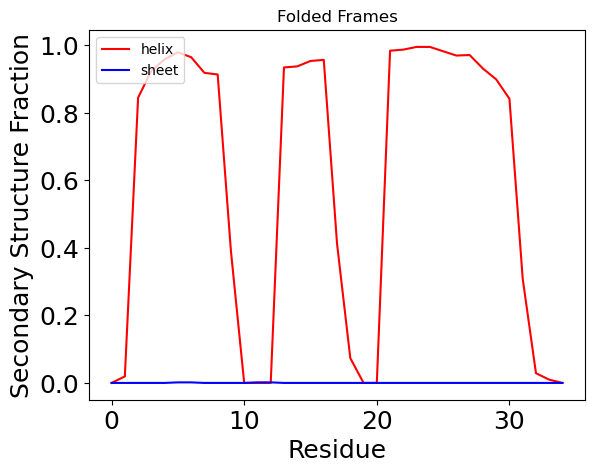

In [82]:
Hprop,Eprop=dssp_convert(dssp[folded_frames])
plt.plot(Hprop,c='r',label='helix')
plt.plot(Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Structure Fraction', size=18)
plt.tick_params(labelsize=18)
plt.title('Folded Frames')

Text(0.5, 1.0, 'Intermediate Frames')

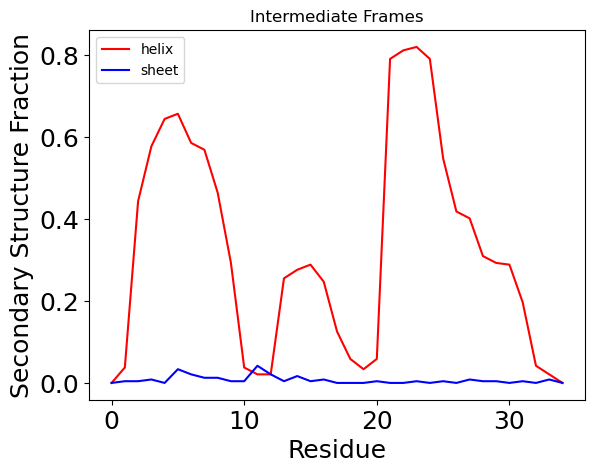

In [83]:
Hprop,Eprop=dssp_convert(dssp[intermed_frames])
plt.plot(Hprop,c='r',label='helix')
plt.plot(Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Structure Fraction', size=18)
plt.tick_params(labelsize=18)
plt.title('Intermediate Frames')

Starting to see that middle helix form! Cool! There's also more beta sheet here than in the entirely unfolded/folded frame plots which is interesting. 

Text(0.5, 1.0, 'Transition Frames')

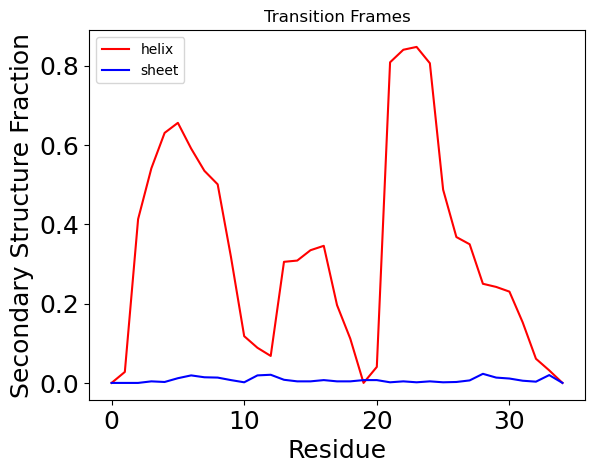

In [84]:
Hprop,Eprop=dssp_convert(dssp[transition_path_indices])
plt.plot(Hprop,c='r',label='helix')
plt.plot(Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Structure Fraction', size=18)
plt.tick_params(labelsize=18)
plt.title('Transition Frames')

Thinking back to the previous example with looking at the full transition, we saw a much clearer difference between the initial unfolded state, transition state, and the final folded state. Here, the fact that the transition state almost perfectly resembles the intermediate frames suggests there's not another big transition/stable secondary state in between these frames. We do see that there is slightly more beta sheet in the intermediate frames compared to the transition, suggesting that perhaps as villin folds it might very very rapidly/minorly sample a somewhat beta sheet conformation. But, this is a superrrr small negligible effect. Still an interesting thing to note as it shows that the folding pathway isn't a perfectt linear/straightforward stabilization of the helix. 

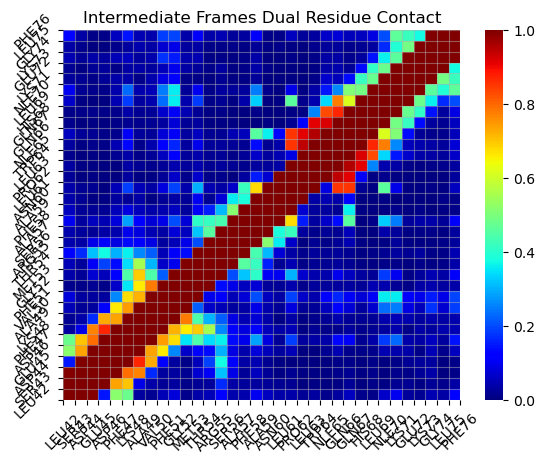

In [85]:
ax = sns.heatmap(contact[intermed_frames].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Intermediate Frames Dual Residue Contact')
plt.show()

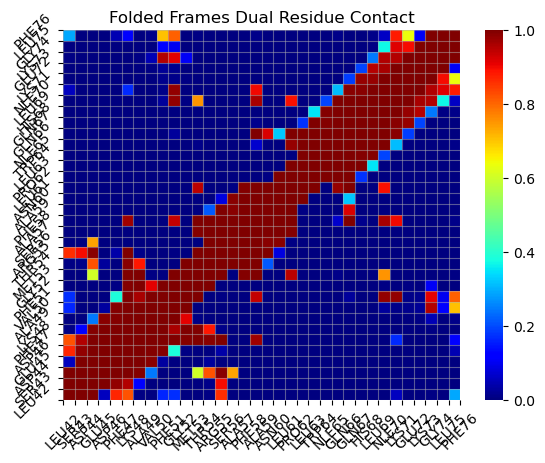

In [86]:
ax = sns.heatmap(contact[folded_frames].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Folded Frames Dual Residue Contact')
plt.show()

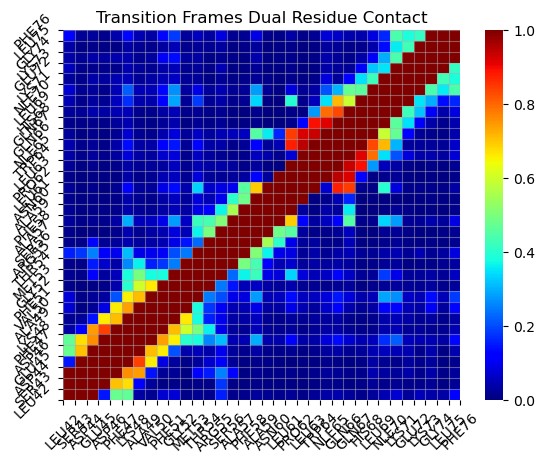

In [87]:
ax = sns.heatmap(contact[transition_path_indices].mean(0), vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.title('Transition Frames Dual Residue Contact')
plt.show()

These maps match the secondary structure maps above! We see a very similar transition path/intermediate frames contact map, showing that the two states are essentially the same. There are some contacts in the intermediate frames not present here (especially around the 42-48 residue stretch), which likely matches that super tiny spike in beta sheet. It's an interesting effect to visualize deviations from the unfolded to helix folding. 